# Import modules

In [4]:
import time
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow_datasets as tfds
import tensorflow as tf

# Load the dataset
## Vulgar Latin and Italian words

In [2]:
df = pd.read_csv('./it-vl-ascii.csv')
df.head()

,italian,vulgar_latin
0,abbacchiare,abbaclare
1,abbattere,abbatto
2,abbeverare,abbiberare
3,abbracciare,adbracchiare
4,abbrustolire,brustulare


## Split the dataset

In [162]:
# permutate
df = df.sample(len(df))

X_final = df.vulgar_latin.values[-10:]
y_final = df.italian.values[-10:]

lt_ds = df.vulgar_latin.values[:-10]
it_ds = df.italian.values[:-10]

X_train, X_test, y_train, y_test = train_test_split(lt_ds, it_ds, test_size=0.2)

# Tokenizer

In [163]:
class Tokenizer:
    """tokenization of words
    """    
    def __init__(self):
        self.vocabs = ['[PAD]', '[UNK]', '[START]', '[END]'] + list(string.ascii_lowercase)
        range = np.arange(len(self.vocabs))
        self.conv_to_id = dict(zip(self.vocabs, range))
        self.conv_to_word = dict(zip(range, self.vocabs))

    def get_vocab_size(self):
        return len(self.vocabs)

    """ tokenization """

    def word_to_id(self, word):
        if word in self.conv_to_id:
            return self.conv_to_id[word]
        else:
            return self.conv_to_id['[UNK]']

    def tokenize_sentence(self, sentence):
        tok = [self.word_to_id(word) for word in list(sentence)]
        tok = [self.conv_to_id['[START]']] + tok + [self.conv_to_id['[END]']] 
        return tok

    def tokenize_sentences(self, sentences):
        tok = [self.tokenize_sentence(sentence) for sentence in sentences]
        return tok

    """ detokenization """

    def id_to_word(self, id):
        if id in self.conv_to_word:
            return self.conv_to_word[id]
        else:
            return self.conv_to_word[1] # [UNK]

    def detokenize_sentence(self, sentence):
        detok = [self.id_to_word(id) for id in sentence]
        detok = ''.join(detok)
        return detok

    def detokenize_sentences(self, sentences):
        tok = [self.detokenize_sentence(sentence) for sentence in sentences]
        return tok
                

In [164]:
MAX_TOKENS = 128
lttok = Tokenizer()
ittok = Tokenizer()

def prepare_dataset(lt, it):
    """prepare the dataset to input to transformer""" 
    lt = lttok.tokenize_sentences(lt)  # Output is ragged.
    lt = tf.ragged.constant(lt)
    lt = lt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    lt = lt.to_tensor()  # Convert to 0-padded dense Tensor

    it = ittok.tokenize_sentences(it)  # Output is ragged.
    it = tf.ragged.constant(it)
    it = it[:, :(MAX_TOKENS+1)]
    it_inputs = it[:, :-1].to_tensor()  # Drop the [END] tokens
    it_labels = it[:, 1:].to_tensor()   # Drop the [START] tokens

    return (lt, it_inputs), it_labels

In [165]:
tr_dataset = prepare_dataset(X_train, y_train)
tr_dataset = tf.data.Dataset.from_tensor_slices(tr_dataset)

vl_dataset = prepare_dataset(X_test, y_test)
vl_dataset = tf.data.Dataset.from_tensor_slices(vl_dataset)

In [166]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [167]:
# Create training and validation set batches.
train_batches = make_batches(tr_dataset)
val_batches = make_batches(vl_dataset)

# Transformer methods and classes

In [168]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

In [169]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [170]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [171]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [172]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [173]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [174]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x


In [175]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [176]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [177]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [178]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [179]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

# Training

In [180]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [181]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=lttok.get_vocab_size(),
    target_vocab_size=ittok.get_vocab_size(),
    dropout_rate=dropout_rate)

In [182]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [183]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [184]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [185]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [186]:
N_EPOCHS = 80

In [ ]:
transformer.fit(train_batches,
                epochs=N_EPOCHS,
                validation_data=val_batches)

## Run inference

In [188]:
class Translator(tf.Module):
  def __init__(self, lttok, ittok, transformer):
    self.lttok = lttok
    self.ittok = ittok
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Vulgar Latin, hence adding the `[START]` and `[END]` tokens.
    # It's done inside tokenize_sentence()

    sentence = self.lttok.tokenize_sentence(sentence)
    encoder_input = tf.constant(sentence)[tf.newaxis]

    # As the output language is Italian, initialize the output with the
    # Italian `[START]` token.
    start, _, end = self.lttok.tokenize_sentence([''])
    start = tf.constant(start, dtype=tf.int64)[tf.newaxis]
    end = tf.constant(end, dtype=tf.int64)[tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    text = self.ittok.detokenize_sentence(output[0][1:-1].numpy())

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, attention_weights

In [189]:
translator = Translator(lttok, ittok, transformer)

In [190]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [192]:
test_preds = [dict(input=X, prediction=translator(X)[0], ground_truth=y) for X, y in zip(X_final, y_final)]
df_test_preds = pd.DataFrame(test_preds)
df_test_preds

,input,prediction,ground_truth
0,lusciniolus,loscinolo,lusignolo
1,jeniperus,genvero,ginepro
2,artefacto,arteffare,artefatto
3,speclum,specchio,specchio
4,torsus,torso,trozza
5,tiro,tiro,tirare
6,manum gemellam,manoglio,giumella
7,exseperare,sceverare,sceverare
8,stantia,stanza,stanza
9,vela,vela,vela


## Create attention plots

The `Translator` class you created in the previous section returns a dictionary of attention heatmaps you can use to visualize the internal working of the model.

For example:

In [194]:
sentence = 'speclum'
ground_truth = "specchio"

translated_text, attention_weights = translator(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : speclum
Prediction     : specchio
Ground truth   : specchio


Create a function that plots the attention when a token is generated:

In [201]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label for label in in_tokens]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label for label in translated_tokens]
  ax.set_yticklabels(labels)

In [202]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 9])

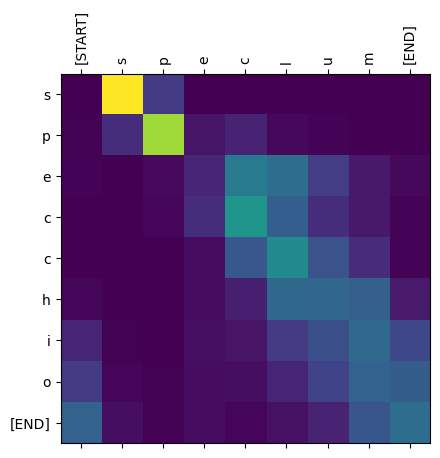

In [205]:

in_tokens = ['[START]'] + list('speclum') + ['[END]']
translated_tokens =  ['[START]'] + list('specchio') + ['[END]']

plot_attention_head(in_tokens, translated_tokens, attention)